Credits to the Experts (Please like their kernels)<br>
Ashish Gupta: [24+ top lgbm models outputs](https://www.kaggle.com/roydatascience/lgmodels)<br>
Konstantin: [ieee-internal-blend](https://www.kaggle.com/kyakovlev/ieee-internal-blend)<br>

In [9]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import glob
import gc

from scipy.stats import describe
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Stacking Approach using GMEAN

In [141]:
leak_df = pd.read_feather('leak.feather')

leak_df.fillna(0, inplace=True)
leak_df = leak_df[(leak_df.timestamp.dt.year > 2016) & (leak_df.timestamp.dt.year < 2019)]
leak_df.loc[leak_df.meter_reading < 0, 'meter_reading'] = 0 # remove large negative values
leak_df = leak_df[leak_df.building_id!=245]

In [84]:
LABELS = ["meter_reading"]
all_files = glob.glob('*.csv')
my_all_files = glob.glob('./prediction/*.csv')
all_files += my_all_files
all_files

['submission_Highway.csv',
 'submission_Half.csv',
 'submission_KFold.csv',
 'submission_ucf_replaced.csv',
 './prediction/submission_noleak_2019-12-17.csv',
 './prediction/submission_2019-12-18_4.csv',
 './prediction/submission_2019-12-18_5.csv',
 './prediction/submission_2019-12-18_1.csv',
 './prediction/submission_2019-12-19_TargetEnc_1.csv',
 './prediction/submission_2019-12-19_TargetEnc_3.csv',
 './prediction/submission_2019-12-18_2.csv',
 './prediction/submission_2019-12-18_3.csv',
 './prediction/submission_2019-12-19_TargetEnc_2.csv',
 './prediction/submission_2019-12-20_TargetEnc_4.csv',
 './prediction/submission_2019-12-17_1.csv',
 './prediction/submission_noleak_2019-12-18_2.csv',
 './prediction/submission_noleak_2019-12-18.csv']

In [127]:
stack_files = []
for i in [1, 4, 9, 11, 12, 13]:
    stack_files.append(all_files[i])
stack_files

['submission_Half.csv',
 './prediction/submission_noleak_2019-12-17.csv',
 './prediction/submission_2019-12-19_TargetEnc_3.csv',
 './prediction/submission_2019-12-18_3.csv',
 './prediction/submission_2019-12-19_TargetEnc_2.csv',
 './prediction/submission_2019-12-20_TargetEnc_4.csv']

### 7つで5分ほど

In [128]:
#outs = [pd.read_csv(all_files[f], index_col=0) for f in top]
concat_sub = pd.DataFrame()
for file in stack_files:
    df = pd.read_csv(file, index_col=0)
    df['log_meter_reading'] = np.log1p(df['meter_reading'])
    concat_sub = pd.concat([concat_sub, df['log_meter_reading']], axis=1)
    del df
    gc.collect()
#outs = [pd.read_csv(file, index_col=0) for file in stack_files]
#concat_sub = pd.concat(outs, axis=1)
cols = list(map(lambda x: "m" + str(x), range(len(concat_sub.columns))))
concat_sub.columns = cols
#del outs
#gc.collect()

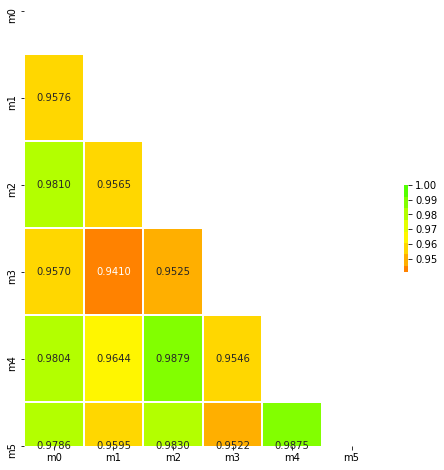

In [129]:
# check correlation
corr = concat_sub.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(len(cols)+2, len(cols)+2))

# Draw the heatmap with the mask and correct aspect ratio
_ = sns.heatmap(corr,mask=mask,cmap='prism',center=0, linewidths=1,
                annot=True,fmt='.4f', cbar_kws={"shrink":.2})

# Select models with low average correlation

In [130]:
mean_corr = corr.mean()
mean_corr = mean_corr.sort_values(ascending=True)
mean_corr = mean_corr[:5]
mean_corr

m3    0.959567
m1    0.963191
m0    0.975785
m5    0.976816
m2    0.976833
dtype: float64

# GMEAN of models with low average correlation

In [131]:
m_gmean1 = 0
for n in mean_corr.index:
    m_gmean1 += np.log(concat_sub[n])
m_gmean1 = np.exp(m_gmean1/len(mean_corr))

In [132]:
m_gmean1.isnull().any()

False

# Weighted GMEAN by inverse correlation

In [133]:
rank = np.tril(corr.values,-1)
rank[rank<0.92] = 1
m = (rank>0).sum() - (rank>0.98).sum()
m_gmean2, s = 0, 0
for n in range(m):
    mx = np.unravel_index(rank.argmin(), rank.shape)
    w = (m-n)/m
    m_gmean2 += w*(np.log(concat_sub.iloc[:,mx[0]])+np.log(concat_sub.iloc[:,mx[1]]))/2
    s += w
    rank[mx] = 1
m_gmean2 = np.exp(m_gmean2/s)

In [134]:
m_gmean2.isnull().any()

False

# Top Blends weighted by score
Based on: https://www.kaggle.com/muhakabartay/0-8518-what-proper-weights-give-ieee-int-blend

In [135]:
m

10

In [136]:
scores = [#0.9965962171554565, # 1
          1.0053532123565674, # 2
          0.9920561909675598, # 5
          0.978188157081604, # 10
          1.0345211029052734, # 12
          0.9919650554656982, # 13
          0.9891604781150818] # 14
top_mean = 0
s = 0
for n in range(5):
    top_mean += concat_sub.iloc[:,n]*scores[n]
    s += scores[n]
top_mean /= s

# GMEAN Final Stacking

In [137]:
m_gmean = np.exp(0.3*np.log(m_gmean1) + 0.2*np.log(m_gmean2) + 0.5*np.log(top_mean))
describe(m_gmean)

DescribeResult(nobs=41697600, minmax=(0.0, 11.12549079499754), mean=4.233050341626145, variance=3.0671341963115686, skewness=-0.10945605658683438, kurtosis=-0.03322308769855331)

In [138]:
import datetime
today = str(datetime.date.today())

In [139]:
test_df = pd.read_feather('./results/test.feather')

In [142]:
leak_df = leak_df.merge(test_df[['building_id', 'meter', 'timestamp', 'row_id']], left_on = ['building_id', 'meter', 'timestamp'], right_on = ['building_id', 'meter', 'timestamp'], how = "left")
del test_df
gc.collect()
leak_df.head(20)

,building_id,meter,meter_reading,timestamp,row_id
0,0,0.0,173.370293,2017-01-01,0
1,1,0.0,53.512720,2017-01-01,1
2,2,0.0,6.143042,2017-01-01,2
3,3,0.0,101.701470,2017-01-01,3
4,4,0.0,1141.240666,2017-01-01,4
5,5,0.0,13.651204,2017-01-01,5
6,6,0.0,260.874513,2017-01-01,6
7,7,0.0,502.705590,2017-01-01,7
8,7,1.0,717.574038,2017-01-01,8
9,8,0.0,513.285268,2017-01-01,9


### 1.5 min

In [143]:
m_gmean.isnull().any()

False

In [144]:
concat_sub['meter_reading'] = m_gmean
leak_df = leak_df[['meter_reading', 'row_id']].set_index('row_id').dropna()
concat_sub.loc[leak_df.index, 'meter_reading'] = leak_df['meter_reading']
#concat_sub[['meter_reading']].to_csv(f'stack_gmean_{today}_2.csv')

In [145]:
concat_sub.index.name = 'row_id'

In [148]:
concat_sub[['meter_reading']].head(20)

,meter_reading
row_id,
0,173.370293
1,53.512720
2,6.143042
3,101.701470
4,1141.240666
5,13.651204
6,260.874513
7,502.705590
8,717.574038


In [147]:
concat_sub[['meter_reading']].to_csv(f'stack_gmean_{today}_2.csv')

In [52]:
df1 = pd.read_csv('./outputs/prediction_target_enc/kernel_best_0.9532.csv')
df2 = pd.read_csv('./outputs/ensemble/stack_gmean_2019-10-04_2.csv')
df1['isFraud'] = 0.7 * df1['isFraud'] + 0.3 * df2['isFraud']
df1.head()

,TransactionID,isFraud
0,3663549,0.000662
1,3663550,0.001756
2,3663551,0.001186
3,3663552,0.000980
4,3663553,0.001326


In [54]:
df1.to_csv(f'./outputs/ensemble/blending_{today}.csv', index=False)